In [96]:
from dataclasses import dataclass
import datetime
from germansentiment import SentimentModel
import html
import matplotlib.pyplot as plt
import pandas as pd 
import re
import seaborn as sns
import snscrape.modules.twitter as sntwitter
import sqlite3
import torch

In [2]:
pd.set_option('display.max_colwidth', None)
db_file = 'tweets-de.db'

In [3]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except sqlite3.Error as e:
        print(e)

    return conn

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except sqlite3.Error as e:
        print(e)

In [4]:
@dataclass
class Query:
    search_term: str
    lang: str
    date_from: datetime.datetime
    date_to: datetime.datetime
    period: str = "Unspecified"

    def __post_init__(self):
        if (self.period == "Unspecified"):
            self.period = self.date_from.strftime('%Y') + '-' + self.date_to.strftime('%Y')

    def __str__(self):
        return(self.search_term  + " lang:" + self.lang + " until:" + self.date_to.strftime('%Y-%m-%d') + " since:" + self.date_from.strftime('%Y-%m-%d'))

In [5]:
def preprocess_tweet(tweet):
    tweet.rawContent = html.unescape(tweet.rawContent)
    tweet.rawContent = re.sub("@[A-Za-z0-9_]+", "", tweet.rawContent).strip()
    tweet.rawContent = re.sub("#", "", tweet.rawContent).strip()
    tweet.rawContent = re.sub(r"http\S+", "", tweet.rawContent)
    tweet.rawContent = re.sub("(\\n)+", " ", tweet.rawContent)
    tweet.rawContent = re.sub("(\\'er)", "er", tweet.rawContent)
    if tweet.hashtags is not None:
        tweet.hashtags = ";".join(tweet.hashtags)
    return tweet

In [6]:
def gather_tweets_to_sql(query, conn, limit = 100):
    sql_insert = ''' INSERT INTO tweets(id, date, user, lang, search_term, period, content, hashtags, sentiment)
              VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?) '''
    i = 0
    for tweet in sntwitter.TwitterSearchScraper(str(query)).get_items():
        if i == limit:
            break
        else:
            i += 1
            tweet = preprocess_tweet(tweet)
            sql_tweet= (tweet.id, tweet.date, tweet.user.username, tweet.lang, query.search_term, query.period, tweet.rawContent, tweet.hashtags, None)
            cur = conn.cursor()
            cur.execute(sql_insert, sql_tweet)
            conn.commit()

In [7]:
def recode_sentiment(sentiment):
    if sentiment == "positive":
        return 1
    elif sentiment == "negative":
        return -1
    else:
        return 0

In [8]:
sql_create_tweets_table = """CREATE TABLE tweets (
                                       id integer NOT NULL,
                                       date TIMESTAMP NOT NULL,
                                       user TEXT NOT NULL,
                                       lang TEXT NOT NULL,
                                       search_term TEXT NOT NULL,
                                       period TEXT NOT NULL,
                                       content TEXT NOT NULL,
                                       hashtags TEXT,
                                       sentiment integer,
                                       PRIMARY KEY (id, search_term));"""

In [286]:
# create a database connection
conn = create_connection(db_file)
create_table(conn, sql_create_tweets_table)
conn.close()

<function Connection.close()>

In [288]:
search_terms = ["Berlin", "Hamburg", "Köln", "München", "Frankfurt"]
years_from = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
limit = 10000
conn = create_connection(db_file)
for s in search_terms:
    for y in years_from:
        q = Query(s, "de", datetime.datetime(y, 12, 31), datetime.datetime(y+1, 1, 2))
        gather_tweets_to_sql(q, conn, limit)
conn.close()

<function Connection.close()>

In [9]:
model = SentimentModel()

In [19]:
sql_select = "SELECT id, content FROM tweets ORDER BY id LIMIT ? OFFSET ?"
sql_update = "UPDATE tweets SET sentiment = ? WHERE id = ?"
conn = create_connection(db_file)
cur = conn.cursor()

cur.execute("SELECT COUNT(*) from tweets")
n_rows = cur.fetchone()[0]
batch_size = 1000
offset = 0
while True:
    cur.execute(sql_select, (batch_size, offset))
    batch = pd.DataFrame(list(cur), columns = ['id', 'content'])
    batch['sentiment'] = list(map(recode_sentiment, model.predict_sentiment(batch['content'])))
    batch = batch[['sentiment', 'id']].values.tolist()
    cur.executemany(sql_update, batch)
    offset += batch_size
    if (offset >= n_rows):
        break
conn.commit()
conn.close()


In [20]:
del model
torch.cuda.empty_cache()

In [22]:
conn = create_connection(db_file)
cur = conn.cursor()
cur.execute("SELECT search_term, period, sentiment FROM tweets")
df = pd.DataFrame(list(cur), columns = ['search_term', 'period', 'sentiment'])
conn.commit()
conn.close()

In [73]:
df_aggr = df.groupby(['search_term','period', 'sentiment']).size().reset_index(name='counts')
df_aggr
df_aggr = pd.pivot(df_aggr, index=['search_term', 'period'], columns='sentiment', values='counts')
df_aggr = df_aggr.reset_index()
df_aggr.columns = ['City', 'Period', 'N_Negative', 'N_Neutral', 'N_Positive']
df_aggr['N_Total'] = df_aggr['N_Negative'] + df_aggr['N_Neutral'] + df_aggr['N_Positive']
df_aggr['N_Negative/N_Positive'] = df_aggr['N_Negative'] / df_aggr['N_Positive'] 
df_aggr.head()

,City,Period,N_Negative,N_Neutral,N_Positive,N_Total,N_Negative/N_Positive
0,Berlin,2012-2013,1274,6832,700,8806,1.820000
1,Berlin,2013-2014,758,4417,543,5718,1.395948
2,Berlin,2014-2015,1011,5818,583,7412,1.734134
3,Berlin,2015-2016,940,5758,535,7233,1.757009
4,Berlin,2016-2017,901,4724,488,6113,1.846311


[None, None, None, None, None, None, None, None, None, None]

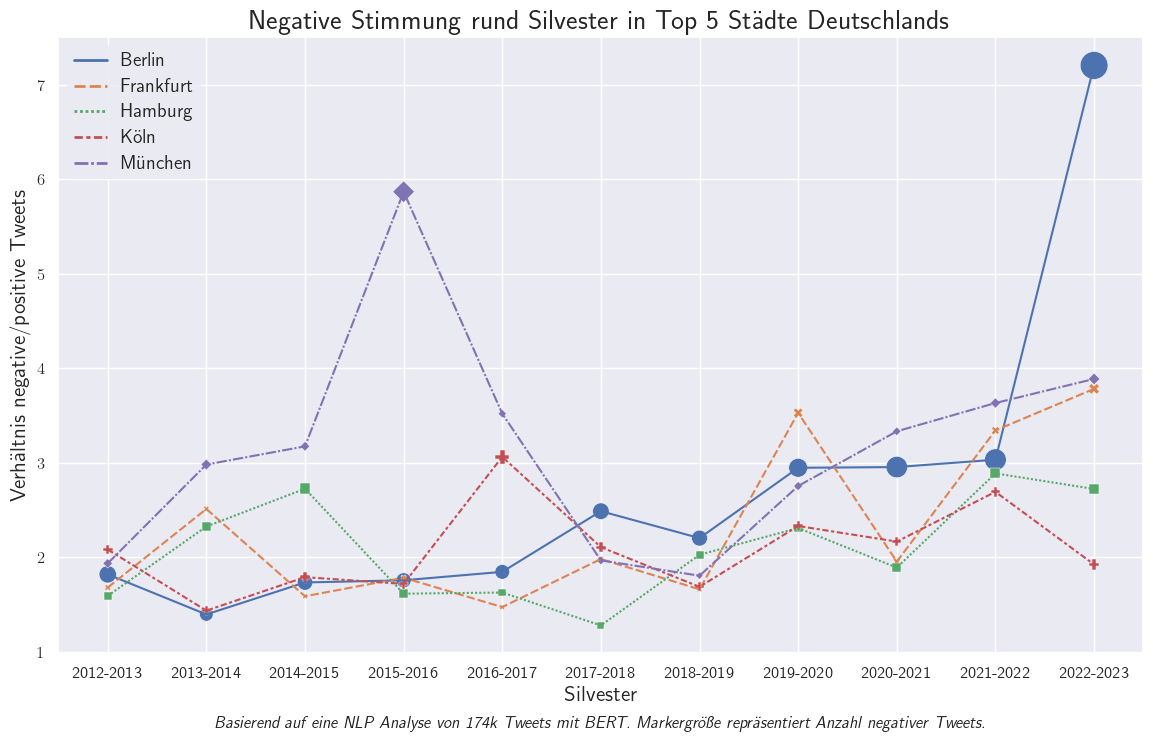

In [235]:
sns.set(rc={'figure.figsize':(14,8), 'text.usetex' : True, "font.family": "sans-serif", "font.serif": "Go", "font.sans-serif": "Go"})
sns.set_style("dark")
sns.set(font_scale = 1.1)
caption="Basierend auf eine NLP Analyse von 174k deutschsprachigen Tweets mit BERT. Markergröße repräsentiert Anzahl negativer Tweets."
plt.figure()
ax1 = sns.lineplot(data=df_aggr, x="Period", y="N_Negative/N_Positive", hue="City", style="City", markers=False, legend="brief", palette ='deep')
ax2 = sns.scatterplot(data=df_aggr, x="Period", y="N_Negative/N_Positive", hue="City", style="City", size="N_Negative",  sizes=(15, 400), legend=False, palette ='deep')
ax1.set_xlabel(r'\begin{center}Silvester\\*\textit{\large{' + caption + r'}}\end{center}', fontsize=15.5)
#ax1.axes.set_xlabel("Silvester", fontsize=15.5)
ax1.axes.set_ylabel("Verhältnis negative/positive Tweets", fontsize=15.5)
ax1.axes.set_title("Negative Stimmung rund Silvester in Top 5 Städte Deutschlands", fontsize=20)
ax1.get_legend().set_title(None)
for line in ax1.get_legend().get_lines():
    line.set_linewidth(2.0)
ax1.get_legend().get_frame().set_linewidth(0.0)
plt.setp(ax1.get_legend().get_texts(), fontsize='14') # for legend text